In [37]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [4]:
# open prompt file
file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
tree_prompt = file_prompt["treeMLDstar"]

# read only pT branch
pt = tree_prompt["fPt"].array(library="np")

# apply pT cut: 6 < pT < 8
mask = (pt > 6.0) & (pt < 8.0)
pt_cut = pt[mask]

print("Total prompt candidates:", len(pt))
print("Prompt candidates in 6–8 GeV/c:", len(pt_cut))
print(file_prompt.keys())
tree_prompt.keys()

Total prompt candidates: 797119
Prompt candidates in 6–8 GeV/c: 108544
['treeMLDstar;1']


['fCandidateSelFlag',
 'fChi2PCAD0',
 'fCosThetaStarD0',
 'fCpaD0',
 'fCpaXYD0',
 'fDecayLengthD0',
 'fDecayLengthNormalisedD0',
 'fDecayLengthXYD0',
 'fDecayLengthXYNormalisedD0',
 'fEta',
 'fEtaD0',
 'fFlagMcMatchRec',
 'fImpParamSoftPi',
 'fImpactParameter0',
 'fImpactParameter1',
 'fImpactParameterNormalised0',
 'fImpactParameterNormalised1',
 'fImpactParameterNormalisedSoftPi',
 'fImpactParameterProductD0',
 'fM',
 'fMD0',
 'fMaxNormalisedDeltaIPD0',
 'fNSigTofKa0',
 'fNSigTofKa1',
 'fNSigTofKaSoftPi',
 'fNSigTofPi0',
 'fNSigTofPi1',
 'fNSigTofPiSoftPi',
 'fNSigTpcKa0',
 'fNSigTpcKa1',
 'fNSigTpcKaSoftPi',
 'fNSigTpcPi0',
 'fNSigTpcPi1',
 'fNSigTpcPiSoftPi',
 'fNSigTpcTofKa0',
 'fNSigTpcTofKa1',
 'fNSigTpcTofKaSoftPi',
 'fNSigTpcTofPi0',
 'fNSigTpcTofPi1',
 'fNSigTpcTofPiSoftPi',
 'fPhi',
 'fPhiD0',
 'fPt',
 'fPtBhadMother',
 'fPtD0',
 'fPtProng0',
 'fPtProng1',
 'fPtSoftPi',
 'fY',
 'fYD0',
 'fInvDeltaMass']

In [8]:

def count_pt_range(filename, ptmin=6.0, ptmax=8.0):
    file = uproot.open(filename)
    print("Upper level keys:",file.keys())
    tree = file["treeMLDstar"]
    pt = tree["fPt"].array(library="np")
    mask = (pt > ptmin) & (pt < ptmax)
    return len(pt), np.sum(mask)

files = {
    "Prompt": "Prompt_DstarToD0Pi.root",
    "Nonprompt": "Nonprompt_DstarToD0Pi.root",
    "Background": "Bkg_DstarToD0Pi.root"
}

for label, fname in files.items():
    total, selected = count_pt_range(fname)
    print(f"{label:12s} | Total: {total:9d} | 6<pT<8: {selected:9d}")


Upper level keys: ['treeMLDstar;1']
Prompt       | Total:    797119 | 6<pT<8:    108544
Upper level keys: ['treeMLDstar;1']
Nonprompt    | Total:    988954 | 6<pT<8:    134532
Upper level keys: ['treeMLDstar;1']
Background   | Total:  11163103 | 6<pT<8:    701622


In [12]:

# Global configuration (fixed for Step 3)
PT_MIN, PT_MAX = 6.0, 8.0
NSAMPLE = 50000

FILES = {
    "Prompt": "Prompt_DstarToD0Pi.root",
    "Nonprompt": "Nonprompt_DstarToD0Pi.root",
    "Background": "Bkg_DstarToD0Pi.root"
}

def plot_variable(var_name, xlabel=None, nbins=60):
    """
    Plot normalized distributions of a given variable
    for Prompt, Non-prompt, and Background D* candidates.
    
    Parameters
    ----------
    var_name : str
        Name of the branch to plot (e.g. 'fCpaD0')
    xlabel : str, optional
        Label for x-axis (defaults to var_name)
    nbins : int
        Number of histogram bins
    """
    
    data = {}

    for label, fname in FILES.items():
        tree = uproot.open(fname)["treeMLDstar"]
        
        arrays = tree.arrays([var_name, "fPt"], library="np")
        mask = (arrays["fPt"] > PT_MIN) & (arrays["fPt"] < PT_MAX)
        
        values = arrays[var_name][mask]
        
        # safety check
        if len(values) < NSAMPLE:
            raise ValueError(f"Not enough entries in {label} for {var_name}")
        
        idx = np.random.choice(len(values), NSAMPLE, replace=False)
        data[label] = values[idx]

    # plotting
    plt.figure(figsize=(8,6))
    
    for label, values in data.items():
        plt.hist(values, bins=nbins, density=True,
                 histtype='step', linewidth=2, label=label)

    plt.xlabel(xlabel if xlabel else var_name)
    plt.ylabel("Normalized candidate density")
    plt.title(f"{var_name} distribution (6 < pT < 8 GeV/c)")
    plt.legend()
    plt.grid(True)
    plt.show()


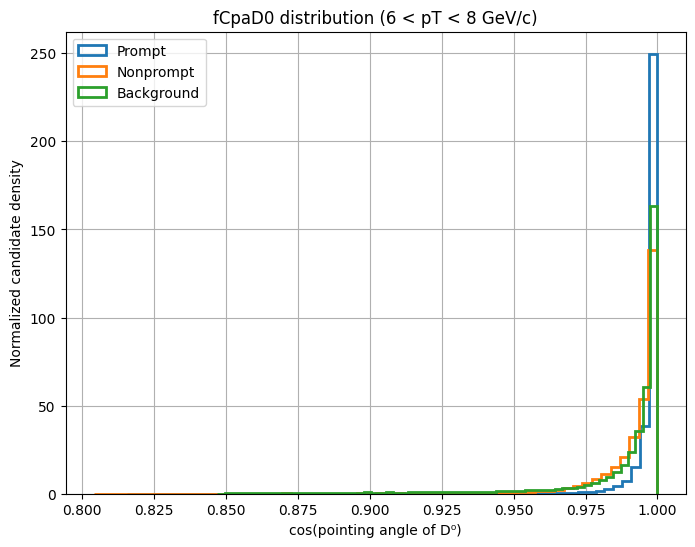

In [13]:
plot_variable("fCpaD0", xlabel="cos(pointing angle of D⁰)")


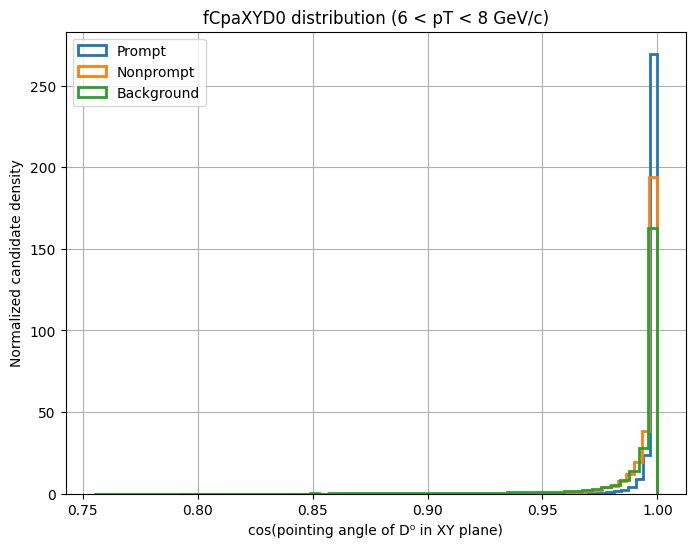

In [14]:
plot_variable("fCpaXYD0", xlabel="cos(pointing angle of D⁰ in XY plane)")


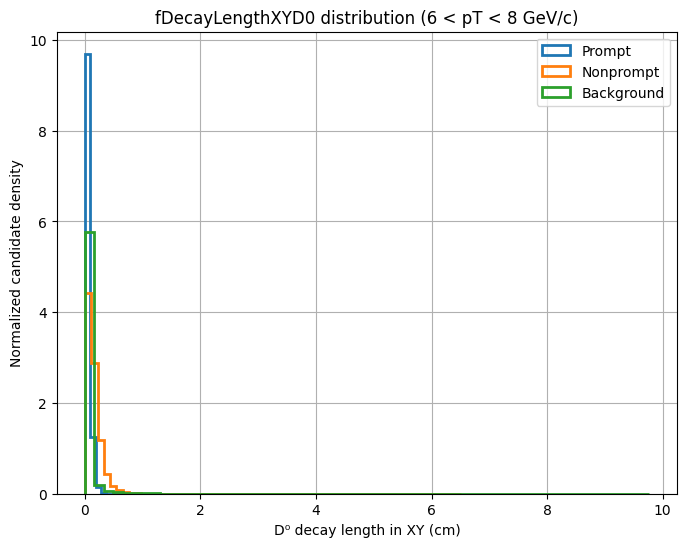

In [15]:
plot_variable("fDecayLengthXYD0", xlabel="D⁰ decay length in XY (cm)")


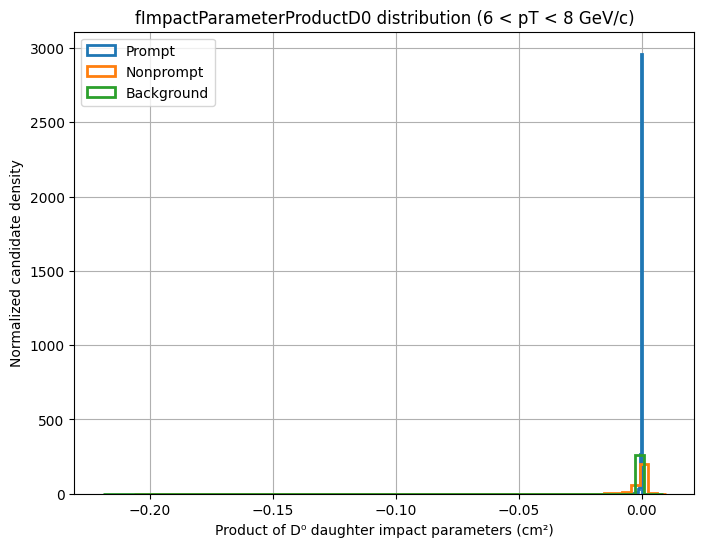

In [16]:
plot_variable(
    "fImpactParameterProductD0",
    xlabel="Product of D⁰ daughter impact parameters (cm²)"
)


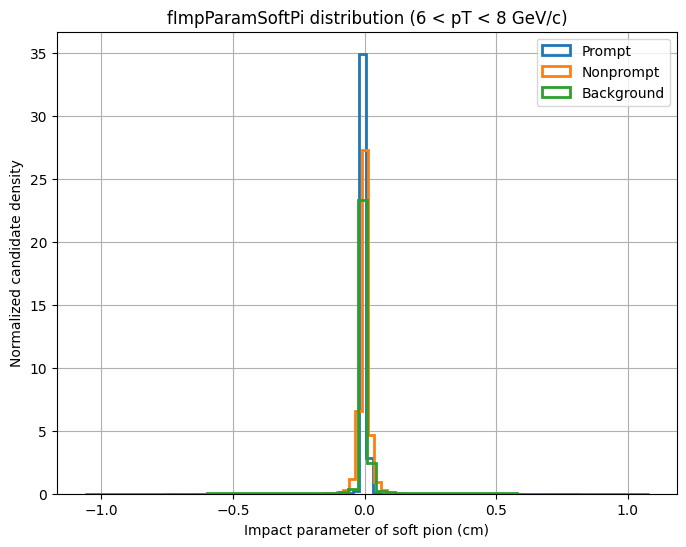

In [17]:
plot_variable(
    "fImpParamSoftPi",
    xlabel="Impact parameter of soft pion (cm)"
)


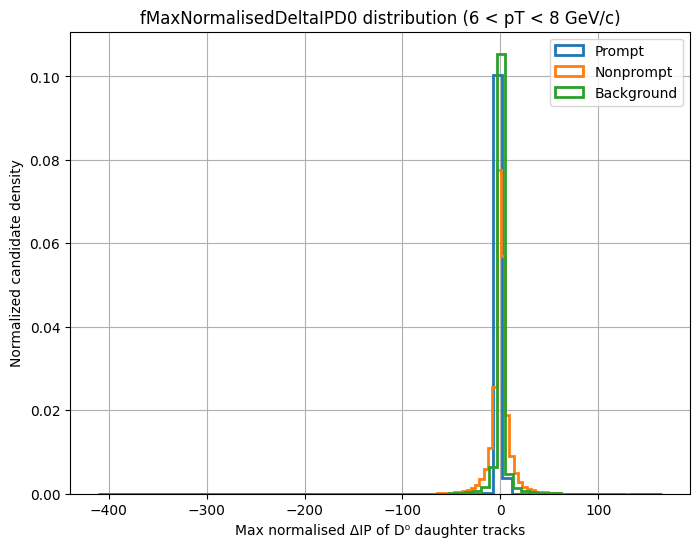

In [18]:
plot_variable(
    "fMaxNormalisedDeltaIPD0",
    xlabel="Max normalised ΔIP of D⁰ daughter tracks"
)


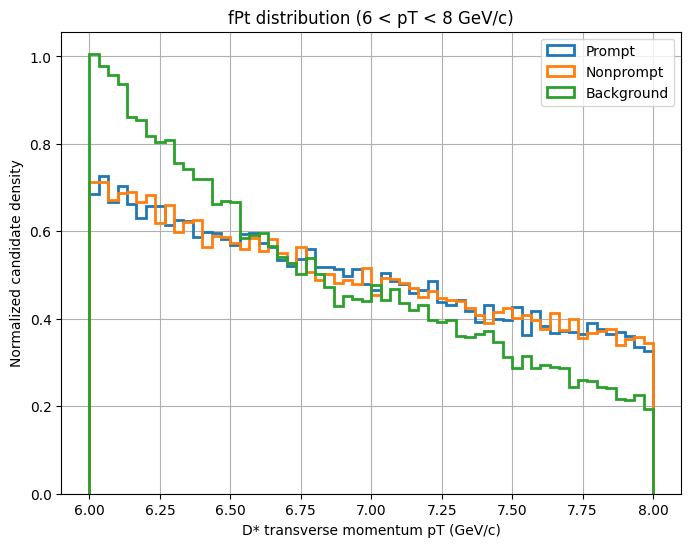

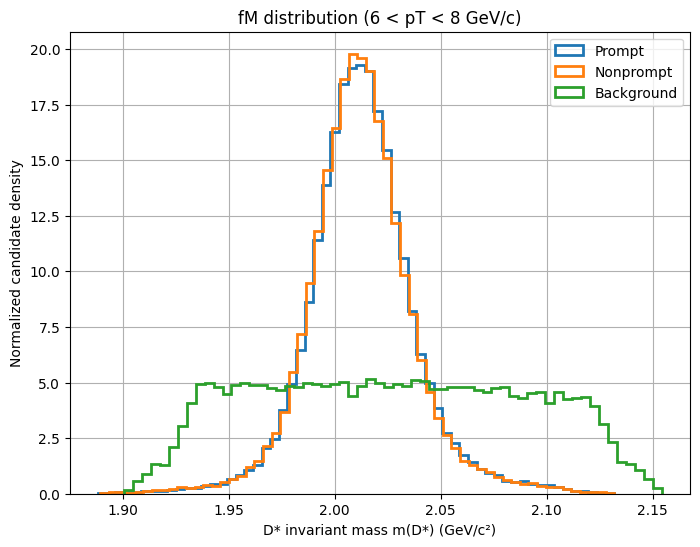

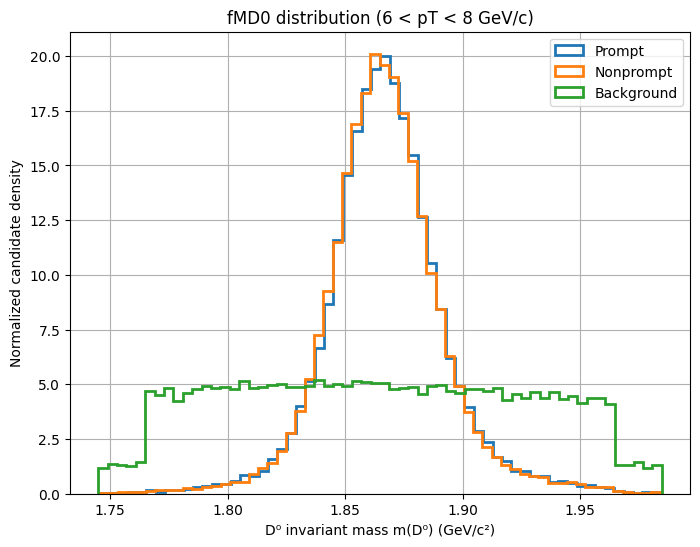

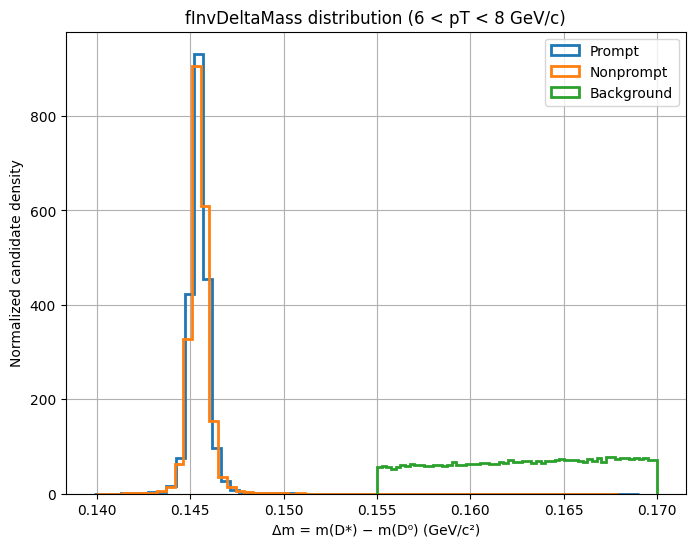

In [19]:
plot_variable("fPt", "D* transverse momentum pT (GeV/c)")
plot_variable("fM", "D* invariant mass m(D*) (GeV/c²)")
plot_variable("fMD0", "D⁰ invariant mass m(D⁰) (GeV/c²)")
plot_variable("fInvDeltaMass", "Δm = m(D*) − m(D⁰) (GeV/c²)")


In [23]:
file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
file_nonprompt = uproot.open("Nonprompt_DstarToD0Pi.root")
file_bkg = uproot.open("Bkg_DstarToD0Pi.root")

tree_prompt = file_prompt["treeMLDstar"]
tree_nonprompt = file_nonprompt["treeMLDstar"]
tree_bkg = file_bkg["treeMLDstar"]


In [24]:
topo_vars = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",
    "fPt"  # needed for pT selection
]

data_prompt = tree_prompt.arrays(topo_vars, library="np")
data_nonprompt = tree_nonprompt.arrays(topo_vars, library="np")
data_bkg = tree_bkg.arrays(topo_vars, library="np")


In [25]:

def select_pt_range(data, pt_min=6, pt_max=8):
    mask = (data["fPt"] > pt_min) & (data["fPt"] < pt_max)
    return {var: data[var][mask] for var in topo_vars}

prompt_sel = select_pt_range(data_prompt)
nonprompt_sel = select_pt_range(data_nonprompt)
bkg_sel = select_pt_range(data_bkg)

# Combine all classes
combined = {
    var: np.concatenate([
        prompt_sel[var],
        nonprompt_sel[var],
        bkg_sel[var]
    ])
    for var in topo_vars
}

df = pd.DataFrame(combined)


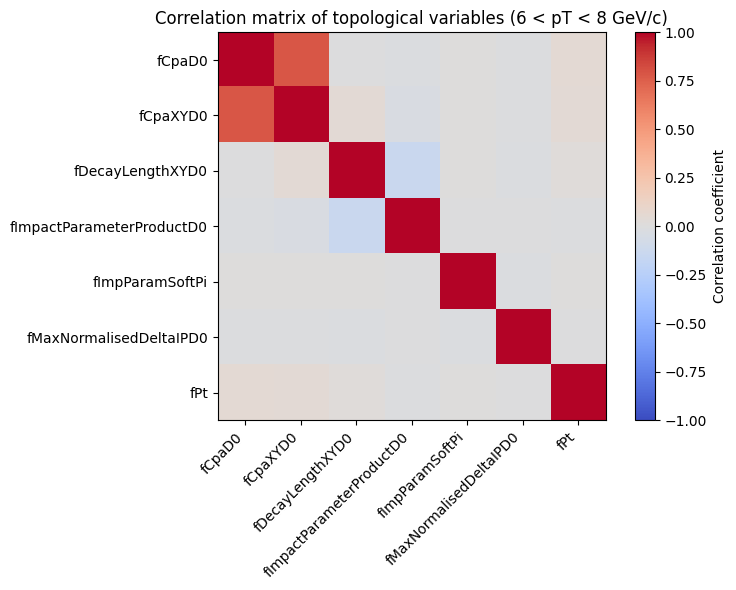

In [26]:
corr = df.corr()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation coefficient")

labels = df.columns
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

plt.title("Correlation matrix of topological variables (6 < pT < 8 GeV/c)")
plt.tight_layout()
plt.show()


In [31]:

features = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0"
]

def build_xy(data, label, pt_min=6, pt_max=8):
    mask = (data["fPt"] > pt_min) & (data["fPt"] < pt_max)
    X = np.column_stack([data[var][mask] for var in features])
    y = np.full(X.shape[0], label)
    return X, y

# Labels: 0 = Bkg, 1 = Prompt, 2 = Nonprompt
X_prompt, y_prompt = build_xy(data_prompt, 1)
X_nonprompt, y_nonprompt = build_xy(data_nonprompt, 2)
X_bkg, y_bkg = build_xy(data_bkg, 0)

X = np.vstack([X_prompt, X_nonprompt, X_bkg])
y = np.concatenate([y_prompt, y_nonprompt, y_bkg])


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [33]:

model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    max_depth=4,
    n_estimators=200,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

In [34]:
model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [35]:
# Predict class probabilities on TEST set
y_score = model.predict_proba(X_test)

# Split scores by true class
scores_bkg = y_score[y_test == 0]
scores_prompt = y_score[y_test == 1]
scores_nonprompt = y_score[y_test == 2]


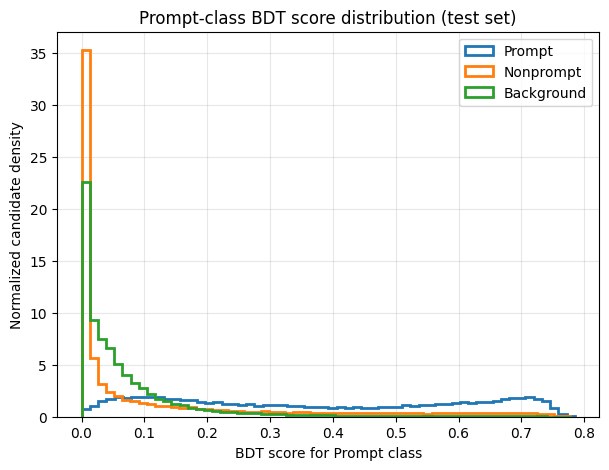

In [36]:

plt.figure(figsize=(7,5))

plt.hist(scores_prompt[:,1], bins=60, density=True,
         histtype="step", linewidth=2, label="Prompt", color="tab:blue")
plt.hist(scores_nonprompt[:,1], bins=60, density=True,
         histtype="step", linewidth=2, label="Nonprompt", color="tab:orange")
plt.hist(scores_bkg[:,1], bins=60, density=True,
         histtype="step", linewidth=2, label="Background", color="tab:green")

plt.xlabel("BDT score for Prompt class")
plt.ylabel("Normalized candidate density")
plt.title("Prompt-class BDT score distribution (test set)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [38]:
# y_test: true labels (shape: [N])
# y_score: predicted probabilities (shape: [N, 3])

# Sanity check
print(y_score.shape)


(283410, 3)


In [44]:
# Select only prompt and background
mask_pb = (y_test == 0) | (y_test == 2)

y_true_pb = (y_test[mask_pb] == 2).astype(int)   # prompt = 1, bkg = 0
y_score_pb = y_score[mask_pb, 2]                 # prompt probability

fpr_pb, tpr_pb, thresholds_pb = roc_curve(y_true_pb, y_score_pb)
auc_pb = auc(fpr_pb, tpr_pb)


In [45]:
mask_pnp = (y_test == 1) | (y_test == 2)

y_true_pnp = (y_test[mask_pnp] == 2).astype(int)   # prompt = 1, nonprompt = 0
y_score_pnp = y_score[mask_pnp, 2]

fpr_pnp, tpr_pnp, _ = roc_curve(y_true_pnp, y_score_pnp)
auc_pnp = auc(fpr_pnp, tpr_pnp)


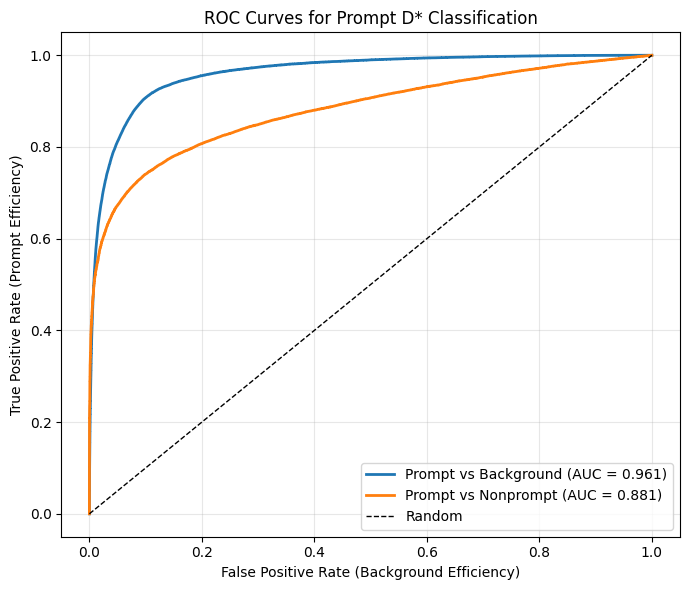

In [46]:
plt.figure(figsize=(7,6))

plt.plot(fpr_pb, tpr_pb, lw=2,
         label=f'Prompt vs Background (AUC = {auc_pb:.3f})')

plt.plot(fpr_pnp, tpr_pnp, lw=2,
         label=f'Prompt vs Nonprompt (AUC = {auc_pnp:.3f})')

plt.plot([0,1], [0,1], 'k--', lw=1, label='Random')

plt.xlabel('False Positive Rate (Background Efficiency)')
plt.ylabel('True Positive Rate (Prompt Efficiency)')
plt.title('ROC Curves for Prompt D* Classification')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [47]:
# fpr_pb, tpr_pb, thresholds_pb already exist

target_eff = 0.85

# find index closest to 85% prompt efficiency
idx = np.argmin(np.abs(tpr_pb - target_eff))

bdt_cut = thresholds_pb[idx]

print(f"Chosen BDT cut = {bdt_cut:.4f}")
print(f"Prompt efficiency ≈ {tpr_pb[idx]:.3f}")
print(f"Background efficiency ≈ {fpr_pb[idx]:.3f}")


Chosen BDT cut = 0.1816
Prompt efficiency ≈ 0.850
Background efficiency ≈ 0.065


In [48]:
# BDT scores for prompt class
scores = y_score[:, 2]

# Apply cut
passed = scores > bdt_cut

# Efficiencies (test set only)
prompt_eff = passed[y_test == 2].mean()
nonprompt_eff = passed[y_test == 1].mean()
bkg_eff = passed[y_test == 0].mean()

print(f"Prompt efficiency     : {prompt_eff:.3f}")
print(f"Nonprompt efficiency  : {nonprompt_eff:.3f}")
print(f"Background efficiency : {bkg_eff:.3f}")


Prompt efficiency     : 0.850
Nonprompt efficiency  : 0.303
Background efficiency : 0.065
